In [65]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
import os
import os.path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from user_function import MyAlgorithm
from alcon_utils import AlconUtils
import numpy as np
import cv2

def read_data(datasetdir, lv):
    alcon = AlconUtils(datasetdir)

    # アノテーションの読み込み
    fn = "target_lv" + lv + ".csv"
    alcon.load_annotations_target(fn)

    fn = "groundtruth_lv" + lv + ".csv"
    alcon.load_annotations_ground(fn)

    # KNNモデルの作成
    dataset = {}
    for bb_id, target in alcon.targets.items():
        img_filename = alcon.get_filename_char( bb_id )
        code = alcon.ground_truth[bb_id][0]
        if code not in dataset:
            dataset[code] = []
        #if len(dataset[code]) == 100:
        #    continue
        img = cv2.imread( img_filename )
        feature = MyAlgorithm.feature_extraction(img)
        dataset[code].append(feature)

    labels = []
    data = []
    classes = sorted(dataset.keys())
    for label, values in dataset.items():
        labels += [classes.index(label)] * len(values)
        data += values

    data = np.asarray(data, dtype=np.float)
    labels = np.asarray(labels, dtype=np.int)
    
    return data, labels, classes
    
def main(datasetdir,lv):
    data, labels, classes = read_data(datasetdir,lv)
    classifier = KNeighborsClassifier()
    classifier.fit(data, labels)

    outputfile = "./model.pkl"
    joblib.dump((classes, classifier), outputfile)

In [66]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

def main_keras_NN(datasetdir, lv):
    data, labels, classes = read_data(datasetdir,lv)


    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.2
    K.tensorflow_backend.set_session(tf.Session(config=config))
    
    batch_size = 128
    num_classes = 46
    epochs = 12
    img_rows, img_cols = 32, 32
    
    data = data.reshape(data.shape[0],img_rows,img_cols,3)
    input_shape = (img_rows, img_cols, 3)
    data = data.astype('float32')
    labels = keras.utils.to_categorical(labels, num_classes)
    
    classifier = Sequential()
    
    classifier.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape,padding='same'))
    classifier.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(128,activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(num_classes, activation='softmax'))
    
    classifier.compile(loss=keras.losses.categorical_crossentropy,
                       optimizer=keras.optimizers.Adadelta(),
                       metrics=['accuracy'])
    
    classifier.fit(data,labels,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=None)

    outputfile = "./model_ueda.pkl"
    classifier.save(outputfile)

    outputfile2 = "./classes_ueda.pkl"
    joblib.dump(classes, outputfile2)
      

In [21]:
if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("usage: python train.py datasetdir lv", file=sys.stderr)
        quit()

    main(sys.argv[1], sys.argv[2])

FileNotFoundError: [Errno 2] No such file or directory: '-f/annotations/target_lv/root/.local/share/jupyter/runtime/kernel-02e6ad4d-d600-4dec-967b-b45a6126667f.json.csv'

In [22]:
main_keras_NN("/share/alcon/dataset/","1")　　　#学習

Epoch 1/12
49353/49353 [==============================] - 10s - loss: 15.5665 - acc: 0.0339    
Epoch 2/12
49353/49353 [==============================] - 10s - loss: 15.0937 - acc: 0.0635    
Epoch 3/12
49353/49353 [==============================] - 10s - loss: 15.0913 - acc: 0.0637    
Epoch 4/12
49353/49353 [==============================] - 10s - loss: 15.0927 - acc: 0.0635    
Epoch 5/12
49353/49353 [==============================] - 8s - loss: 15.0900 - acc: 0.0637     
Epoch 6/12
49353/49353 [==============================] - 6s - loss: 15.0929 - acc: 0.0635     
Epoch 7/12
49353/49353 [==============================] - 6s - loss: 15.0924 - acc: 0.0635     
Epoch 8/12
49353/49353 [==============================] - 6s - loss: 15.0909 - acc: 0.0637     
Epoch 9/12
49353/49353 [==============================] - 6s - loss: 15.0898 - acc: 0.0636     
Epoch 10/12
49353/49353 [==============================] - 6s - loss: 11.3779 - acc: 0.0940     
Epoch 11/12
49353/49353 [==============

In [25]:
model = keras.models.load_model('./model_ueda.pkl')  #学習したデータの読み込み

In [67]:
%pylab inline
import matplotlib.pyplot as plt
alcon = AlconUtils("/share/alcon/dataset/")
# アノテーションの読み込み
fn = "target_lv1.csv"
alcon.load_annotations_target(fn)
fn = "groundtruth_lv1.csv"
alcon.load_annotations_ground(fn)
#model.predict_classes()
idx = '40000'
rect = alcon.targets[idx][1:5]
image = cv2.imread("/share/alcon/dataset/images/"+alcon.targets[idx][0]+".jpg")
#cv2.rectangle(image, rect[0:2], (rect[0]+rect[2],rect[1]+rect[3]),(255,0,0), 2)
#plt.imshow(image[:,:,(2,1,0)])
#plt.imshow(image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2],:])
#print ("/share/alcon/dataset/images"+alcon.targets[idx][0]+".jpg")
x = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2],:].copy()
x = cv2.resize(x,(32,32))
y = x
x = x.reshape((1,32,32,3))
print (alcon.ground_truth[idx])

Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


['U+306B']


In [45]:
pred = model.predict_classes(x)       　　　　　#学習したデータの利用
classes = joblib.load('./classes_ueda.pkl')
classes[pred[0]]

SyntaxError: invalid character in identifier (<ipython-input-45-e9be0fc81ae6>, line 1)

/root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


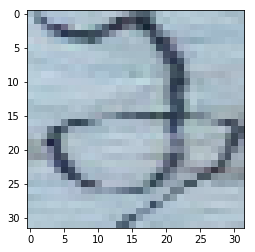

In [68]:
plt.imshow(x.reshape((32,32,3)))

/root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


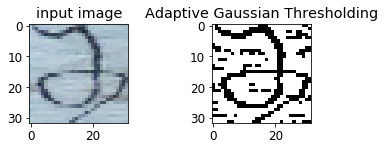

In [78]:
import pylab
pylab.rcParams['font.family'] = 'IPAexGothic'
pylab.rcParams['font.size'] = 12

im = y

im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

#Adaptive Gaussian Thresholding
th1 = cv2.adaptiveThreshold(im_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
"""
neiborhood4 = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]],
                       np.uint8)
th2 = cv2.dilate(th1, neiborhood4, iterations = 1)
th3 = cv2.erode(th2, neiborhood4, iterations = 1)
"""




pylab.subplot(2,2,1),plt.imshow(im,'gray')
pylab.title('input image')
pylab.subplot(2,2,2),plt.imshow(th1,'gray')
pylab.title('Adaptive Gaussian Thresholding')

plt.show()